In [160]:
import matplotlib.pyplot as plt
import pandas as pd
import re
from collections import Counter
from IPython.core.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [161]:
def read_file(file_name):
  with open(file_name) as file:
    text = file.read()
  return text

In [162]:
def split_on_empty_lines(s):
    regex = r"(?:\r?\n){2,}"
    return re.split(regex, s.strip())

def get_jokes_from_file(file_name):
    text = read_file(file_name)
    return split_on_empty_lines(text)


In [163]:
vovochka_jokes = get_jokes_from_file('./vovochka.txt')
# print(len(vovochka_jokes))

In [164]:
computer_jokes = get_jokes_from_file('./computers.txt')
# print(len(computer_jokes))

In [165]:
def union_jokes(arr_1, arr_2):
    jokes_arr = []
    for i in range(len(arr_1)):
        joke_1 = arr_1[i]
        joke_2 = arr_2[i]
        jokes_arr.append({"Номер": 2*i, "Текст": joke_1, "Категорія": 0})
        jokes_arr.append({"Номер": 2*i+1, "Текст": joke_2, "Категорія": 1})
    return jokes_arr

jokes = union_jokes(vovochka_jokes, computer_jokes)
df_jokes = pd.DataFrame(jokes)
df_jokes.to_csv('./jokes.csv', index=False)
display(df_jokes)

100


,Номер,Текст,Категорія
0,0,"Папа спрашивает у Вовочки:\n- Вовочка, что чит...",0
1,1,Компания Microsoft сообщает новости: - В после...,1
2,2,-Вовочка маме\nНу сколько раз я могу повторять...,0
3,3,Народная примета: Если админ при виде вас начи...,1
4,4,Ночь. Однокомнатная квартира. Родители Вовочки...,0
...,...,...,...
95,95,- Избавиться от интернет-зависимости очень лег...,1
96,96,Учительница говорит:\n- Дети скоро праздник - ...,0
97,97,"Вы много смотрите нового русского кино, если з...",1
98,98,Перед 8 марта мама приходит с работы к ней под...,0


In [166]:
df_jokes.head(20).to_csv('./test_10.csv', index=False)
df_jokes.head(40).to_csv('./test_20.csv', index=False)
df_jokes.head(60).to_csv('./test_30.csv', index=False)
df_jokes.tail(40).to_csv('./remainder.csv', index=False)

In [167]:
df_test_10 = pd.read_csv('./test_10.csv')
df_test_20 = pd.read_csv('./test_20.csv')
df_test_30 = pd.read_csv('./test_30.csv')
df_remainder = pd.read_csv('./remainder.csv')

In [168]:
df_first_category = df_jokes[df_jokes["Категорія"] == 0]
df_second_category = df_jokes[df_jokes["Категорія"] == 1]

In [169]:
stop_words = read_file('stop_words.txt').split()

In [170]:
def get_words(text):
  res = re.findall(r'\b[^\d\W]+\b', text.lower())
  return " ".join(res)

def find_most_common_words(df_train, title, delete_stop_words=True):
  df_train['Слова'] = df_train['Текст'].apply(lambda x : get_words(x))
  all_words = ' '.join(df_train["Слова"]).split()
  if delete_stop_words:
    words = [word for word in all_words if not word in stop_words and len(word) > 3]
  else:
      words = all_words
  hist_data = Counter(words).most_common(10)
  fig, ax = plt.subplots(figsize=(20,10))
  ax.tick_params(labelrotation=25, labelsize=20)
  ax.set_title(title, fontsize=40)
  ax.bar(*zip(*hist_data))
  plt.show()

<ipython-input-170-0cd1fa0ab094>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Слова'] = df_train['Текст'].apply(lambda x : get_words(x))


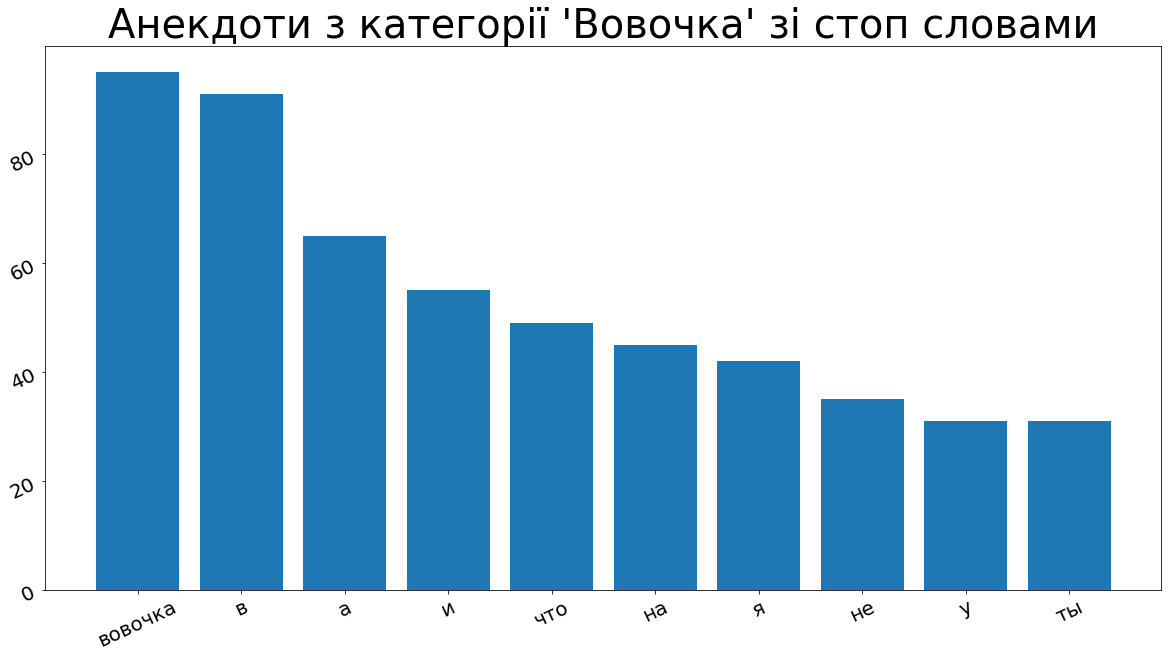

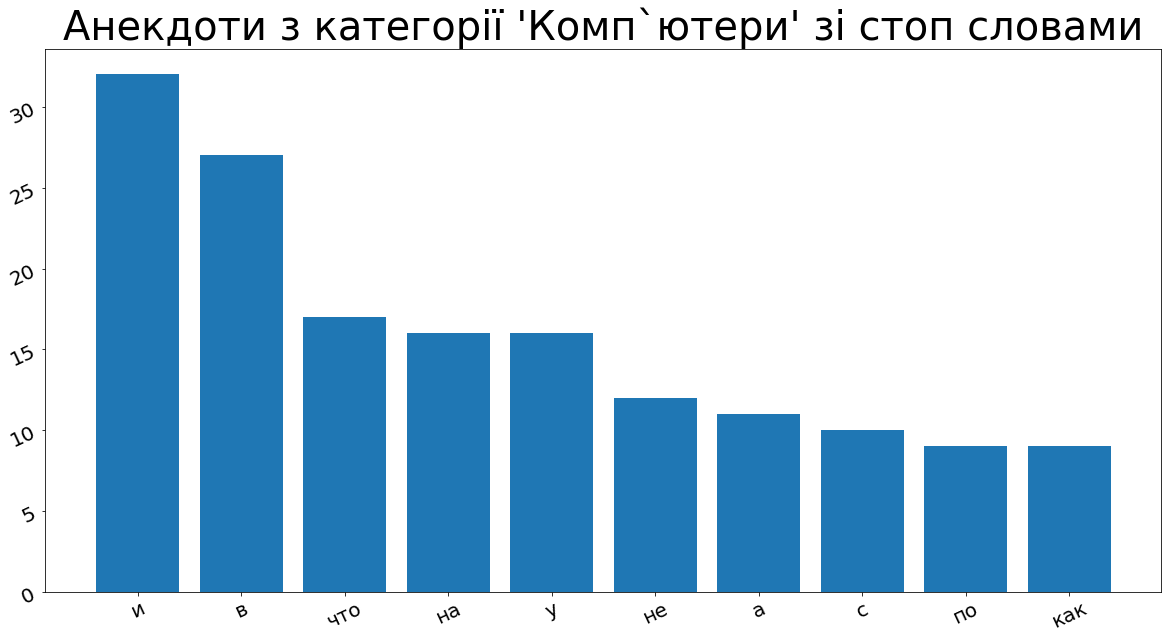

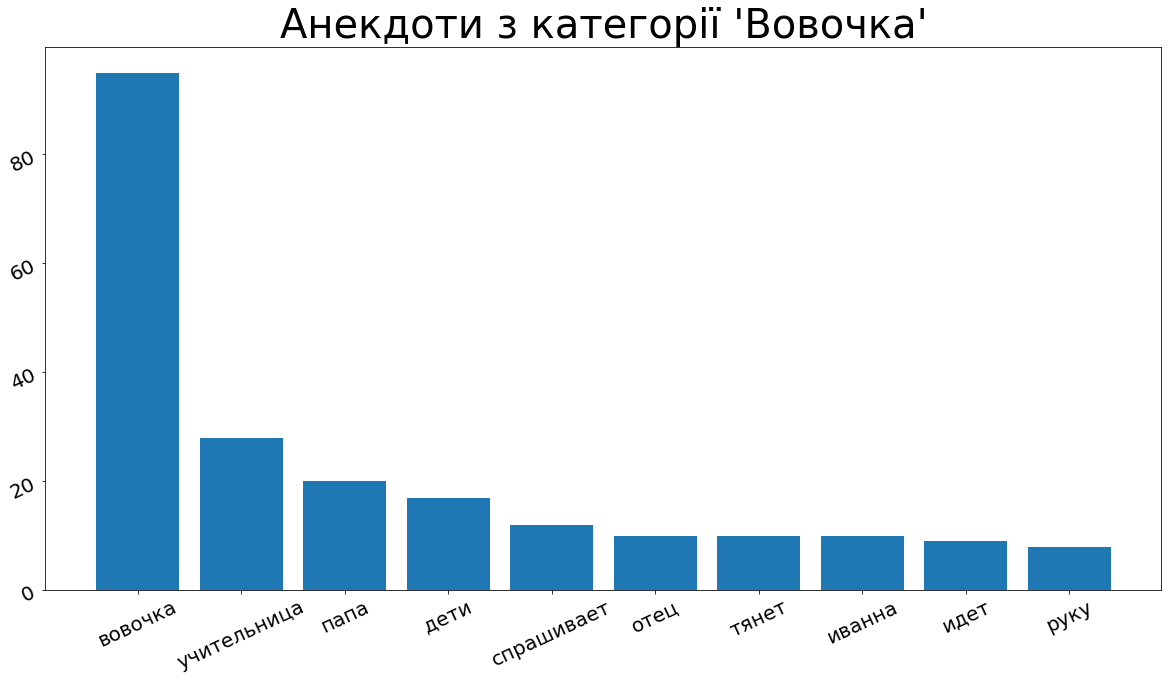

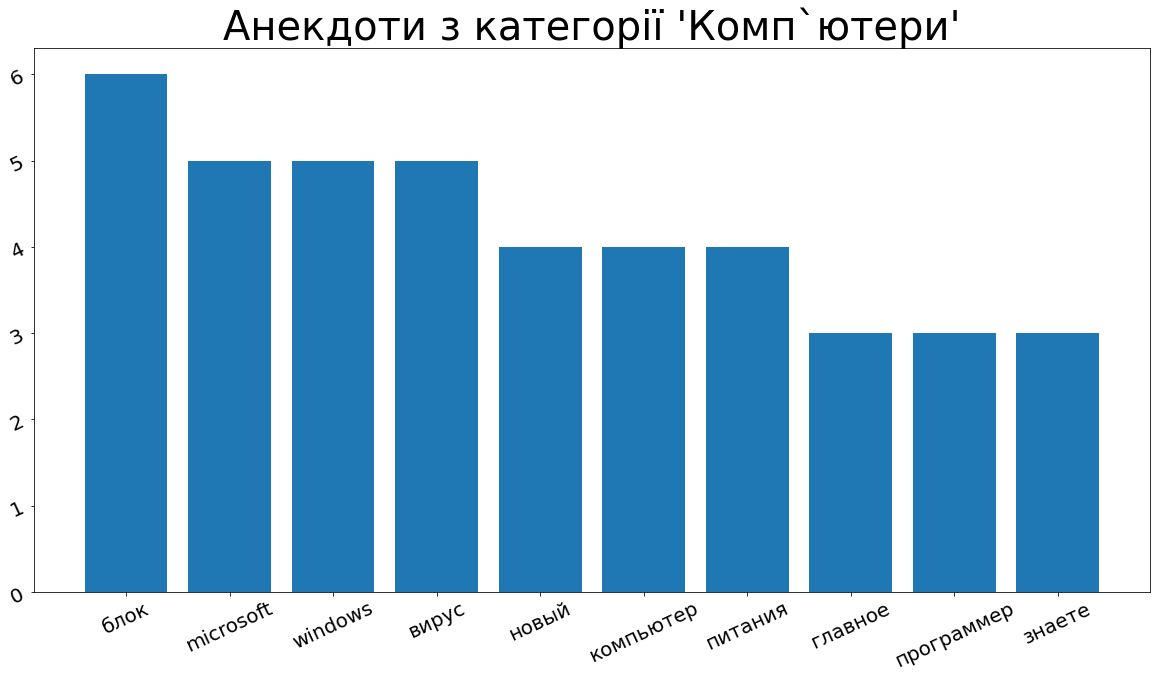

In [171]:
find_most_common_words(df_first_category, "Анекдоти з категорії 'Вовочка' зі стоп словами", delete_stop_words=False)
find_most_common_words(df_second_category, "Анекдоти з категорії 'Комп`ютери' зі стоп словами", delete_stop_words=False)
find_most_common_words(df_first_category, "Анекдоти з категорії 'Вовочка'")
find_most_common_words(df_second_category, "Анекдоти з категорії 'Комп`ютери'")

In [172]:
def process_text(text: str):
  all_words = get_words(text).split()
  words = [word for word in all_words if not word in stop_words]
  return words

In [173]:
pipeline = Pipeline([
   ( "vect",  TfidfVectorizer(analyzer=process_text)),
    ("clf", MultinomialNB())
])

In [174]:
result = []
for i, jokes in enumerate([df_test_10, df_test_20, df_test_30]):
  pipeline.fit(jokes["Текст"], jokes["Категорія"])
  probability = pipeline.predict(df_remainder["Текст"])
  result.append({'Training model': f'Training model {(i + 1) * 10}',
                 'Accuracy Score': accuracy_score(df_remainder["Категорія"], probability)})

In [175]:
df_res = pd.DataFrame(result)
df_res

,Training model,Accuracy Score
0,Training model 10,0.700
1,Training model 20,0.725
2,Training model 30,0.775


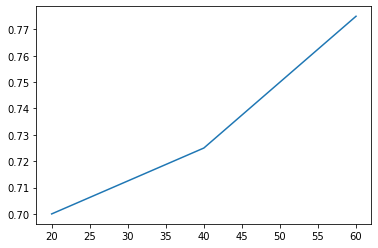

In [176]:
plt.plot([i for i in [10*2,20*2,30*2]], df_res["Accuracy Score"])